In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,LeakyReLU,Flatten,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import time
start =time.process_time()
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [3]:
train = pd.read_csv('cassava-leaf-disease-classification/train.csv')
train.head() 

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train.columns

Index(['image_id', 'label'], dtype='object')

In [5]:
def append_ext(fn):
    return fn+".jpg"

In [6]:
traindf=pd.read_csv("Training_datasets0.csv",dtype=str)
testdf = pd.read_csv("Testing_dataset0.csv",dtype=str)
traindf['id']=traindf['image_id']
testdf['id']=testdf['image_id']

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

In [7]:
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="cassava-leaf-disease-classification/train_images/",
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=128,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))

valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="cassava-leaf-disease-classification/train_images/",
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))

test_datagen=ImageDataGenerator(rescale=1./255.)   
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="cassava-leaf-disease-classification/train_images/",
    x_col="id",
    y_col=None,
    batch_size=128,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(128,128))

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 144 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 13580 validated image filenames belonging to 5 classes.


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 144 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 3394 validated image filenames belonging to 5 classes.
Found 4166 validated image filenames.


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 113 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [8]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [9]:
import pandas as pd

df = pd.read_json('cassava-leaf-disease-classification/label_num_to_disease_map.json',typ='series')

print(df.to_string())

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy


In [10]:
from sklearn.utils import class_weight
import numpy as np
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 3.825352112676056,
 1: 1.972403776325345,
 2: 1.7740039190071848,
 3: 0.32624624624624626,
 4: 1.6591325595601711}

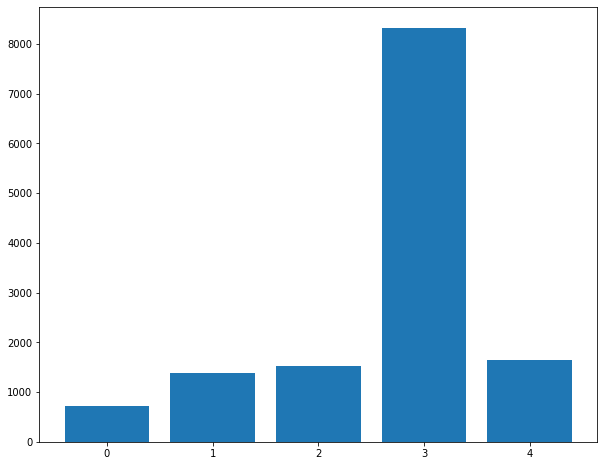

In [11]:
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

cls_train = train_generator.classes
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(10,8))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

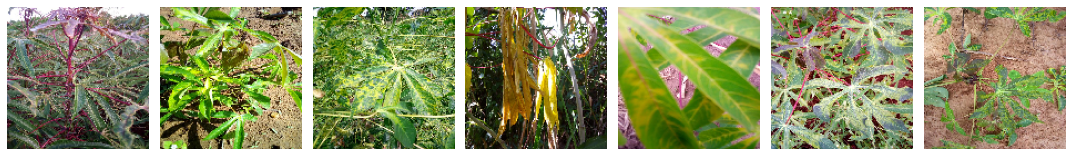

In [13]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:7])

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
image_size = 128
batch_size = 32
input_shape = (image_size, image_size, 3)
base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [15]:
# freeze the model weights
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [16]:
# construct the head of the model that will be placed on top.....
head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dense(5, activation='softmax')(head_model)
model = Model(inputs=base_model.input, outputs=head_model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [20]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

model.compile(optimizer =  Adam(learning_rate = 1e-3,beta_1=0.9, beta_2=0.999), loss ='categorical_crossentropy', metrics=[ tf.keras.metrics.Recall(),'accuracy',tf.keras.metrics.Precision()])


In [21]:
learning_rate_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.7, patience=3, verbose=1, min_delta=1e-4, mode='min')
model_checkpoint = ModelCheckpoint('cassava.hdf5', monitor='loss',verbose=1, save_best_only=True,save_weights_only=True)
model_EarlyStopping = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=7, verbose=0, mode='auto')


In [22]:
history = model.fit(train_generator, epochs = 100, validation_data =valid_generator, validation_steps = 32, shuffle=True, 
                           callbacks=[model_checkpoint, learning_rate_reduce,model_EarlyStopping])
end=time.process_time()
print('Running time: %s Seconds'%(end-start))

Epoch 1/100
107/107 [==============================] - ETA: 0s - loss: 1.1101 - recall_1: 0.5169 - accuracy: 0.6213 - precision_1: 0.6954
Epoch 1: loss improved from inf to 1.11009, saving model to cassava.hdf5
107/107 [==============================] - 104s 919ms/step - loss: 1.1101 - recall_1: 0.5169 - accuracy: 0.6213 - precision_1: 0.6954 - val_loss: 1.1231 - val_recall_1: 0.5840 - val_accuracy: 0.6123 - val_precision_1: 0.6493 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - ETA: 0s - loss: 1.0828 - recall_1: 0.5259 - accuracy: 0.6256 - precision_1: 0.7032
Epoch 2: loss improved from 1.11009 to 1.08278, saving model to cassava.hdf5
107/107 [==============================] - 98s 905ms/step - loss: 1.0828 - recall_1: 0.5259 - accuracy: 0.6256 - precision_1: 0.7032 - val_loss: 1.0760 - val_recall_1: 0.5010 - val_accuracy: 0.6250 - val_precision_1: 0.7145 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - ETA: 0s - loss: 1.0695 - recall_1: 0.5321 - 

KeyboardInterrupt: 

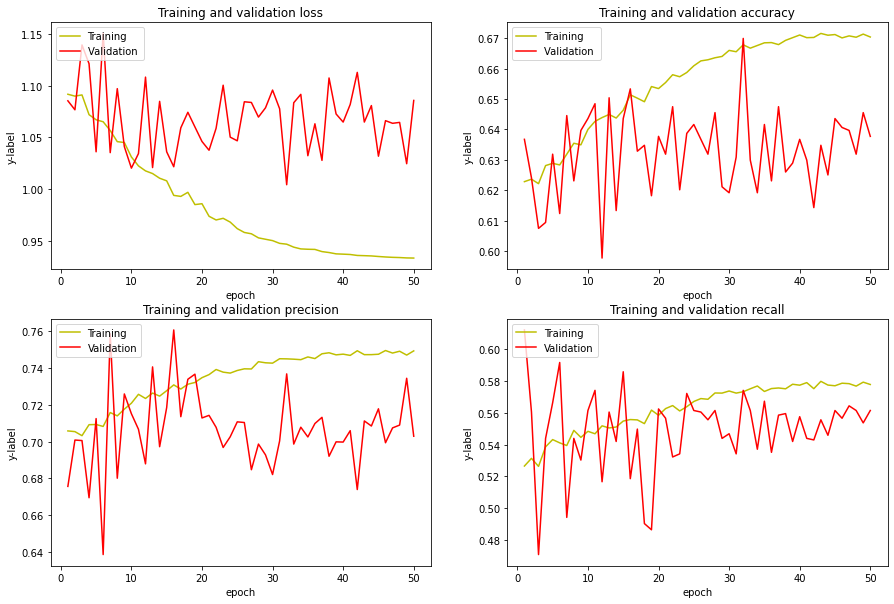

In [29]:
figure, axis = plt.subplots(2, 2, figsize=(15,10))
loss =history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axis[0, 0].plot(epochs, loss, 'y', label='Training ')
axis[0,0].plot(epochs, val_loss, 'r', label='Validation ')
axis[0, 0].set_title('Training and validation loss')
axis[0, 0].legend(loc='upper left')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()



accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
axis[0,1].plot(epochs, accuracy, 'y', label='Training ')
axis[0,1].plot(epochs, val_accuracy, 'r', label='Validation ')
axis[0, 1].set_title('Training and validation accuracy')
axis[0, 1].legend(loc='upper left')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()



precision = history.history['precision_1']
val_precision = history.history['val_precision_1']
axis[1,0].plot(epochs, precision, 'y', label='Training ')
axis[1,0].plot(epochs, val_precision, 'r', label='Validation')
axis[1,0].set_title('Training and validation precision')
axis[1,0].legend(loc='upper left')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

recall = history.history['recall_1']
val_recall = history.history['val_recall_1']
axis[1,1].plot(epochs, recall, 'y', label='Training ')
axis[1,1].plot(epochs, val_recall, 'r', label='Validation')
axis[1,1].set_title('Training and validation recall')
axis[1,1].legend(loc='upper left')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()

for ax in axis.flat:
    ax.set(xlabel='epoch', ylabel='y-label')
plt.show()



107/107 [==============================] - 30s 225ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

           0       0.10      0.04      0.06       162
           1       0.06      0.05      0.05       352
           2       0.10      0.01      0.02       388
           3       0.61      0.84      0.71      2103
           4       0.07      0.03      0.04       398

    accuracy                           0.53      3403
   macro avg       0.19      0.19      0.17      3403
weighted avg       0.41      0.53      0.45      3403



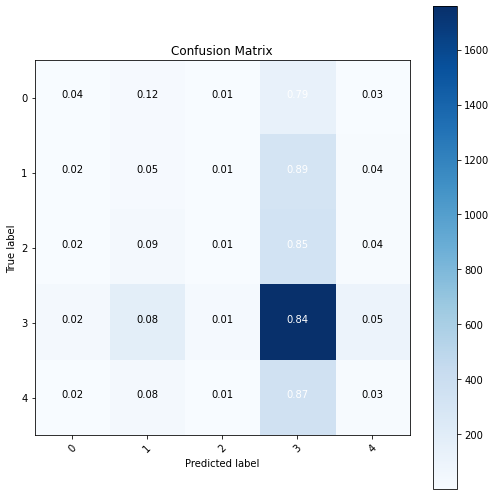

In [30]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))